# Mixed Scale Based on PNAS Paper 

https://github.com/efornaciari/keras-mixed-scale-dense-net

**Did not really work**

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers.merge import concatenate
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table

from decimal import Decimal
import math

directory = '/opt/data/NeuralNetwork/dssi_dwarfs/'
info_file = os.path.join(directory, 'stamps2.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def display_image(position):
    image = train['features'][position].squeeze()
    minim, maxim = np.min(image), np.max(image)
    image = (image - minim) / (maxim - minim)
    plt.figure(1)
    plt.clf()
    plt.title('Example {}. Label: {}'.format(position, train['labels'][position]))
    plt.imshow(image[:,:,:3].astype(np.float64), cmap=plt.cm.gray_r)


def scale_column(column, value):
    vmin, vmax = column_scaling[column]['min'], column_scaling[column]['max']
    return np.clip((value - vmin) / (vmax - vmin), 0, 1)




def random_subsets(thelist, subsets, probabilities=None):
    """
    Create random sugesets of data.

    I need to check to make sure the data exists and is non-zero as well
    """
    used = []

    if probabilities is None:
        probabilities = np.ones(len(thelist))
        
    
    for subset in subsets:
        all_used = list(itertools.chain(*used))

        possible = list(set(thelist) - set(all_used))

        probabilities_subset = probabilities[possible]
        probabilities_subset = probabilities_subset / np.sum(probabilities_subset)

        thesublist = np.random.choice(possible, subset, replace=False, p=probabilities_subset)

        used.append(thesublist)

    return used

## Load the Information File

In [3]:
dwarfs_table = Table.read(info_file, format='ascii.ecsv')
dwarfs_table

<Table length=12558>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps2/d14.79_m7.45_re0.35_feh-1.2_age10.0_HSC.fits  7.4485 ...  0.0349  0.0164
stamps2/d12.46_m6.72_re0.44_feh-1.5_age12.6_HSC.fits  6.7190 ...  0.0245  0.0281
 stamps2/d9.81_m8.47_re0.84_feh-1.0_age12.3_HSC.fits  8.4725 ...  0.0251  0.0167
 stamps2/d14.38_m5.08_re0.47_feh-2.0_age7.0_HSC.fits  5.0823 ...  0.0365  0.0319
stamps2/d11.95_m8.55_re1.34_feh-1.0_age13.7_HSC.fits  8.5475 ...  0.0372  0.0224
  stamps2/d9.74_m5.33_re0.46_feh-1.8_age7.7_HSC.fits  5.3289 ...  0.0179  0.0166
stamps2/d10.94_m5.00_re0.95_feh-1.5_age13.2_HSC.fits  5.0040 ...  0.0202  0.0344
stamps2/d12.95_m5.07_re0.21_feh-2.0_age11.4_HSC.fits  5.0731 ...  0.0233  0.0198
 stamps2/d7.03_m6.23_re0.47_feh-1.8_age11.3_HSC.fits  6.2316 ...  0.0374  0.0274
stamps2/d11.57_m5.17_re0.22_feh-2.0_age11.7_HSC.fits  5.1709 ...  0.0338  0.0230
                                                 ...     ... ...     ...     ...
 stamps2/d3.73_m7.66_re0.45_feh-1.2_age13.1_HSC.fits  7.6571 ...  0.0174  0.0350
 stamps2/d10.51_m5.05_re0.19_feh-2.0_age9.7_HSC.fits  5.0504 ...  0.0291  0.0190
stamps2/d10.23_m8.55_re0.72_feh-1.2_age10.8_HSC.fits  8.5462 ...  0.0320  0.0177
stamps2/d11.71_m6.42_re0.63_feh-1.5_age10.1_HSC.fits  6.4168 ...  0.0397  0.0283
 stamps2/d3.68_m5.31_re0.53_feh-2.0_age14.0_HSC.fits  5.3101 ...  0.0324  0.0192
stamps2/d14.93_m5.67_re0.21_feh-2.0_age12.0_HSC.fits  5.6689 ...  0.0299  0.0189
 stamps2/d11.84_m7.86_re0.43_feh-1.2_age8.2_HSC.fits  7.8559 ...  0.0179  0.0350
  stamps2/d4.90_m7.64_re0.43_feh-1.0_age8.7_HSC.fits  7.6398 ...  0.0163  0.0305
stamps2/d14.13_m5.68_re0.35_feh-1.8_age10.2_HSC.fits  5.6786 ...  0.0234  0.0307
stamps2/d11.39_m8.88_re1.23_feh-1.0_age12.0_HSC.fits  8.8764 ...  0.0161  0.0344

## Setup the Columns of Interest

In [4]:
# Calculate the scale factors for each attribute
#columns = ['distance', 'logmass', 'rekpc', 'FeH', 'age']
columns = ['distance']

column_scaling = {}
for column in columns:
  column_scaling[column] = {
      'min': np.percentile(dwarfs_table[column], 0.01), 
      'max': np.percentile(dwarfs_table[column], 99.99)
}

print('Columns Scaling is {}'.format(column_scaling))

Columns Scaling is {'distance': {'min': 0.86109265, 'max': 14.999248860000002}}


## Custom Data Generator

In [5]:
# Step 1 : Define a function to get input (can be subsetting a numpy array, pandas dataframe, reading in from disk etc.) :
def get_input(path):
    
    f = fits.open(os.path.join(directory, path))
    img = f[0].data.transpose((1, 2, 0)) # move channels to last.
    return(img)


# Step 2 : Define a function to get output :
def get_output(dwarf_table_row, columns):    
    return np.array([scale_column(c, dwarf_table_row[c]) for c in columns])

# Step 3 : Define a function to preprocess input :
def preprocess_input(image):
    
    pnum = np.random.randint(1, 5)
    
    if pnum == 1:
        image = image
    elif pnum == 2:
        image = image[::-1]
    elif pnum == 3:
        image = image[:,::-1]
    elif pnum == 4:
        image = np.roll(image, 3, axis=0)
    elif pnum == 5:
        image = np.roll(image, 3, axis=1)
    
    return(image)


# Step 4 : Bring everything together to define your generator :
def image_generator(dwarfs_table, row_indices, batch_size = 64):
    """
    Need to pass in dwarfs_table
    indices over which we will do a random choice
    """
    while True:
        # Select files (paths/indices) for the batch
        batch_dwarfs_rows = np.random.choice(a=dwarfs_table[row_indices], size=batch_size, replace=False)

        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for row in batch_dwarfs_rows:
            data = get_input(row['filename'])
            output = get_output(row, columns)

            data = preprocess_input(image=data)

            batch_input += [ data ]
            batch_output += [ output ]

        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        #batch_x = vgg19_preprocess_input(batch_x)
        #batch_x = (batch_x - np.min(batch_x)) / (np.max(batch_x) - np.min(batch_x))

        yield batch_x, batch_y


## Load the Data into Test and Train

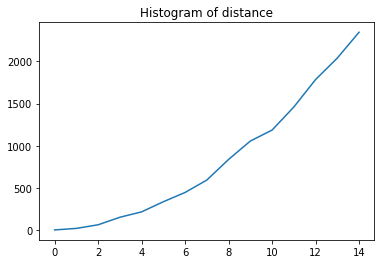

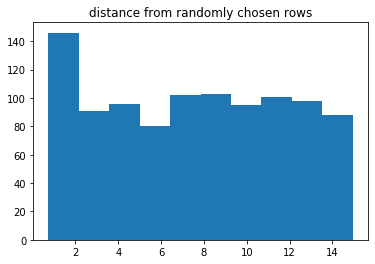

In [6]:
# Get a list of all row indices
indices = range(len(dwarfs_table))

# training indices
counts, bins = np.histogram(dwarfs_table['distance'], np.arange(0, 16))

plt.plot(counts)
plt.title('Histogram of distance')

# Calculate the probability for each point with which we want it chosen.
plookup = (1 / len(counts)) * (1 / counts)
probabilities = np.array([plookup[int(x)] for x in np.floor(dwarfs_table['distance'])])

# As a test we are going to randomly choose 1000 points to make sure that what comes back is a uniform distribution
# of distances.
plt.figure()
out = np.random.choice(dwarfs_table['distance'], 1000, p=probabilities)
plt.hist(out)
plt.title('distance from randomly chosen rows')

training_test_indices = random_subsets(indices, [200, 200, 1000], probabilities=probabilities)
test_indices, validation_indices, training_indices = training_test_indices

## Compile the Neural Network

In [11]:
import sys

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D

from keras import backend as K

from keras import backend as K
from keras.layers.merge import Add

from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils

from keras.engine.topology import Layer
from keras import backend as K
import tensorflow as tf

import keras.backend as K
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

class InputChannels(Layer):
    def __init__(
        self,
        num_input_channels,
        **kwargs
    ):

        """
        InputChannels unstacks Input into number of channels specified.
        
        Args:
            num_input_channels : Number of input channels in input tensor.
        """
        super(InputChannels, self).__init__(**kwargs)
        self.num_input_channels = num_input_channels
        self.supports_masking = True

    def build(self, input_shape):
        super(InputChannels, self).build(input_shape)

    def call(self, x):
        """
        Unstacks x into list of tensors.
        
        Args:
            x : Input Tensor to unstack
        
        Returns:
            List of num_input_channels Tensors.
        """
        return [ K.expand_dims(tensor, axis=-1) for tensor in tf.unstack(x, num=self.num_input_channels, axis=-1) ]

    def compute_output_shape(self, input_shape):
        """
        Computes the output shapes given the input shapes.

        Args:
            input_shape : Shape of input to layer.
        
        Returns:
            Shape of list of num_input_channels Tensors.
        """
        output_shape = []
        single_output_shape = input_shape[:-1] + (1,)
        
        for input_channel in range(self.num_input_channels):
            output_shape.append(single_output_shape)
        return output_shape

class BiasedAdd(Add):

    def __init__(
        self,
        data_format=None,
        activation=None,
        use_bias=True,
        bias_initializer='zeros',
        bias_regularizer=None,
        bias_constraint=None,
        **kwargs
    ):

        self.data_format = normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        super(BiasedAdd, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        # Used purely for shape validation.
        if not isinstance(input_shape, list):
                input_shape = [ input_shape ]
                # raise ValueError('A merge layer should be called on a list of inputs.')

        batch_sizes = [s[0] for s in input_shape if s is not None]
        batch_sizes = set(batch_sizes)
        batch_sizes -= set([None])
        if len(batch_sizes) > 1:
                raise ValueError('Can not merge tensors with different '
                                                 'batch sizes. Got tensors with shapes : ' +
                                                 str(input_shape))
        if input_shape[0] is None:
                output_shape = None
        else:
                output_shape = input_shape[0][1:]
        for i in range(1, len(input_shape)):
                if input_shape[i] is None:
                        shape = None
                else:
                        shape = input_shape[i][1:]
                output_shape = self._compute_elemwise_op_output_shape(output_shape, shape)
        # If the inputs have different ranks, we have to reshape them
        # to make them broadcastable.
        if None not in input_shape and len(set(map(len, input_shape))) == 1:
                self._reshape_required = False
        else:
                self._reshape_required = True


        if self.use_bias:
                self.bias = self.add_weight(shape=(input_shape[0][-1],),
                                                                        initializer=self.bias_initializer,
                                                                        name='bias',
                                                                        regularizer=self.bias_regularizer,
                                                                        constraint=self.bias_constraint,
                                                                        trainable=True)
        else:
                self.bias = None

    def _merge_function(self, inputs):
        outputs = super(BiasedAdd, self)._merge_function(inputs)

        # Apply Bias
        if self.use_bias:
                outputs = K.bias_add(
                        outputs,
                        self.bias,
                        data_format=self.data_format)

        # Apply Activation
        if self.activation is not None:
                outputs = self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list):
                input_shape = [ input_shape ]
        if input_shape[0] is None:
                output_shape = None
        else:
                output_shape = input_shape[0][1:]
        for i in range(1, len(input_shape)):
                if input_shape[i] is None:
                        shape = None
                else:
                        shape = input_shape[i][1:]
                output_shape = self._compute_elemwise_op_output_shape(output_shape, shape)
        batch_sizes = [s[0] for s in input_shape if s is not None]
        batch_sizes = set(batch_sizes)
        batch_sizes -= set([None])
        if len(batch_sizes) == 1:
                output_shape = (list(batch_sizes)[0],) + output_shape
        else:
                output_shape = (None,) + output_shape
        return output_shape

def msdnet(
    num_input_channels,
    network_shape,
    num_output_classes,
    use_dropout=False,
    intermediate_activation="relu",
    output_activation="softmax",
    dropout=0.2,
    filters=1,
    kernel_size=(3,3),
    dilation_rate_fn=None,
    verbose=False,
    **kwargs
):
    """ Construct a Mixed-Scale Dense Net

    Args
        inputs                        : 
        num_classes                : 
        conv_block                : 
        dilation_rate_fn    : 
    """

    width, depth = network_shape

    if dilation_rate_fn is None:
        def __dilation_rate_fn(width, i, j):
            return (i * width + j) % 10 + 1
        dilation_rate_fn = __dilation_rate_fn

    inputs, outputs = __build_model(
        num_input_channels,
        num_output_classes,
        filters,
        kernel_size,
        dilation_rate_fn,
        use_dropout,
        dropout,
        width, depth,
        verbose)
    return Model(inputs=[ inputs ], outputs=[ outputs ])

def __build_input_layer(num_input_channels):
    inputs = Input((256, 256, num_input_channels))
    previous_layers = InputChannels(num_input_channels) (inputs)
    return inputs, previous_layers

# TODO: softmax?
def __build_output_layer(num_classes, previous_layers):
    weighted_feature_maps = []
    for previous_layer in previous_layers:
        weighted_feature_maps.append(Conv2D(1, (1, 1), activation=None, use_bias=False) (previous_layer))
    outputs = BiasedAdd(bias_initializer='random_uniform', activation='relu') (weighted_feature_maps)
#     outputs = Conv2D(num_classes, (1, 1), activation='softmax', use_bias=False) (outputs)

    outputs = layers.Flatten()(outputs)
    outputs = layers.Dropout(0.5)(outputs)

    outputs = layers.Dense(1000, activation='relu')(outputs)
    outputs = layers.Dropout(0.5)(outputs)
    
    outputs = layers.Dense(1000, activation='relu')(outputs)

    outputs = layers.Dense(num_classes, activation='linear')(outputs)
    return outputs

def __build_layer(
    filters,
    kernel_size,
    dilation_rate_fn,
    use_dropout,
    dropout,
    width, depth,
    i,
    previous_layers
):
    current_layers = []
    for j in range(width):
        current_layers.append(
            __build_feature_map(
                filters,
                kernel_size,
                dilation_rate_fn,
                use_dropout, dropout,
                width, depth,
                i, j,
                previous_layers))
    previous_layers.extend(current_layers)
    return previous_layers

def __build_feature_map(
    filters,
    kernel_size,
    dilation_rate_fn,
    use_dropout,
    dropout, 
    width, depth,
    i, j,
    previous_layers
):
    dilated_feature_maps = []
    for previous_layer in previous_layers:
        dilation_rate = dilation_rate_fn(width,i,j)
        dilated_feature_maps.append(Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, activation=None, use_bias=False) (previous_layer))
    outputs = BiasedAdd(bias_initializer='random_uniform', activation='relu') (dilated_feature_maps)
    # Dropout if applicable
    if use_dropout:
            outputs = Dropout(dropout) (outputs)
    return outputs

def __build_model(
    num_input_channels,
    num_classes,
    filters,
    kernel_size,
    dilation_rate_fn,
    use_dropout,
    dropout,
    width, depth,
    verbose
):
    num_total_layers = 2 + depth
    num_current_layers = 0

    def __status_logger(message, num_status_bar):
        CURSOR_UP_ONE = '\x1b[1A'
        ERASE_LINE = '\x1b[2K'
        def __log_status(status, num_current_layers, num_total_layers):
            num_bar = int((1.0 * num_current_layers / num_total_layers) * num_status_bar)
            num_spaces = num_status_bar - num_bar

            status_bar = '=' * num_bar
            if num_spaces > 0:
                status_bar = status_bar + '>'
            else:
                status_bar = status_bar + '='

            status_bar = status_bar + ' ' * num_spaces
            status_bar = '[' + status_bar + ']'
            sys.stdout.write(CURSOR_UP_ONE)
            sys.stdout.write(ERASE_LINE)
            sys.stdout.write("\r{}: {}\n{}".format(message, status, status_bar))
            sys.stdout.flush()
        return __log_status
    
    status_logger = __status_logger('Building Model', 40)

    if verbose:
        status_logger('Adding Input Layer', num_current_layers, num_total_layers)
    inputs, previous_layers = __build_input_layer(num_input_channels)
    num_current_layers = num_current_layers + 1

    for i in range(depth):
        num_current_layers = num_current_layers + 1
        if verbose:
            status_logger("Adding Mixed Dense Layer {}/{}".format(i, depth), num_current_layers, num_total_layers)
        previous_layers = __build_layer(filters, kernel_size, dilation_rate_fn, use_dropout, dropout, width, depth, i, previous_layers)

    num_current_layers = num_current_layers + 1
    if verbose:
        status_logger("Adding Output Layer", num_current_layers, num_total_layers)
    outputs = __build_output_layer(num_classes, previous_layers)
    if verbose:
        status_logger("Done!", num_total_layers, num_total_layers)
    return inputs, outputs


In [12]:
EPOCHS = 10
BATCH_SIZE = 32

model = msdnet(5, (3, 3), 1, verbose=True)

# summarize layers
print(model.summary())


model.summary()

from keras.optimizers import SGD
# sgd = SGD(lr=0.0001, momentum=0.9)
# sgd = SGD()
model.compile(loss='mse', optimizer='adam')

Building Model: Adding Input Layer
Building Model: Adding Mixed Dense Layer 0/3
Building Model: Adding Mixed Dense Layer 1/3
Building Model: Adding Mixed Dense Layer 2/3
Building Model: Adding Output Layer
[=========================================]WARNING:tensorflow:From /home/craig/.pyenv/versions/3.7.2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Building Model: Done!
[=========================================]__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 5)  0                                            
________________________

## Train the Neural Network

In [13]:
train_generator = image_generator(dwarfs_table, training_indices, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
31/31 [==============================] - 882s 28s/step - loss: 2197569.4767 - val_loss: 50.2980
Epoch 2/10
20/31 [==================>...........] - ETA: 4:45 - loss: 950861.1200

KeyboardInterrupt: 

## Show Training Output

In [ ]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               
#score = model.evaluate(test['features'], test['labels'])

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

In [ ]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.astype(np.float16).transpose((1, 2, 0)) # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[12, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])


## Quantitiate Results

In [ ]:
np.sum( (calculated - truth)**2 )

In [ ]:
Ncompare = 500

calculated = np.zeros((Ncompare, len(columns)))
truth = np.zeros((Ncompare, len(columns)))

for ii, test_indice in enumerate(training_indices[:Ncompare]):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.astype(np.float16).transpose((1, 2, 0))[:256, :256] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])
plt.suptitle('Training Data [Subset]')


In [ ]:
train